# Proyek Klasifikasi Gambar: eye_diseases_classification
- **Nama:** Naufal Dzakwan Zakianto
- **Email:** naufal.dzakwann28@gmail.com
- **ID Dicoding:** MC012D5Y2416

## IMPORT LIBRARY YANG DIPERLUKAN

In [3]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [4]:
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [5]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
print(tf.__version__)

2.18.0


In [6]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"naufaldzakwan","key":"8a2220b517066ba766e727d1d73c9202"}'}

## DATA PREPARATION

Dataset yang digunakan berasal dari kaggle yang bisa di akses melalui: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification

Kumpulan data tersebut terdiri dari gambar retina Normal, Retinopati Diabetik, Katarak, dan Glaukoma, yang masing-masing kelasnya memiliki sekitar 1000 gambar, sehingga dataset ini memiliki total gambar sebanyak 4217 gambar. Gambar-gambar tersebut dikumpulkan dari berbagai sumber seperti IDRiD, pengenalan Oculur, HRF, dll.

### DATA LOADING

In [7]:
import kagglehub

eye_path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", eye_path)

Path to dataset files: /kaggle/input/eye-diseases-classification


### DATA PREPROCESSING

In [8]:
class_names = sorted(os.listdir(eye_path+'/dataset'))
num_class = len(class_names)
print(f"Class Names:{class_names}")
print(f"Number of Classes: {num_class}")

Class Names:['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Number of Classes: 4


In [9]:

im = Image.open(eye_path+'/dataset/cataract/0_left.jpg')
width, height = im.size
print(f"width: {width}, height: {height}")

width: 512, height: 512


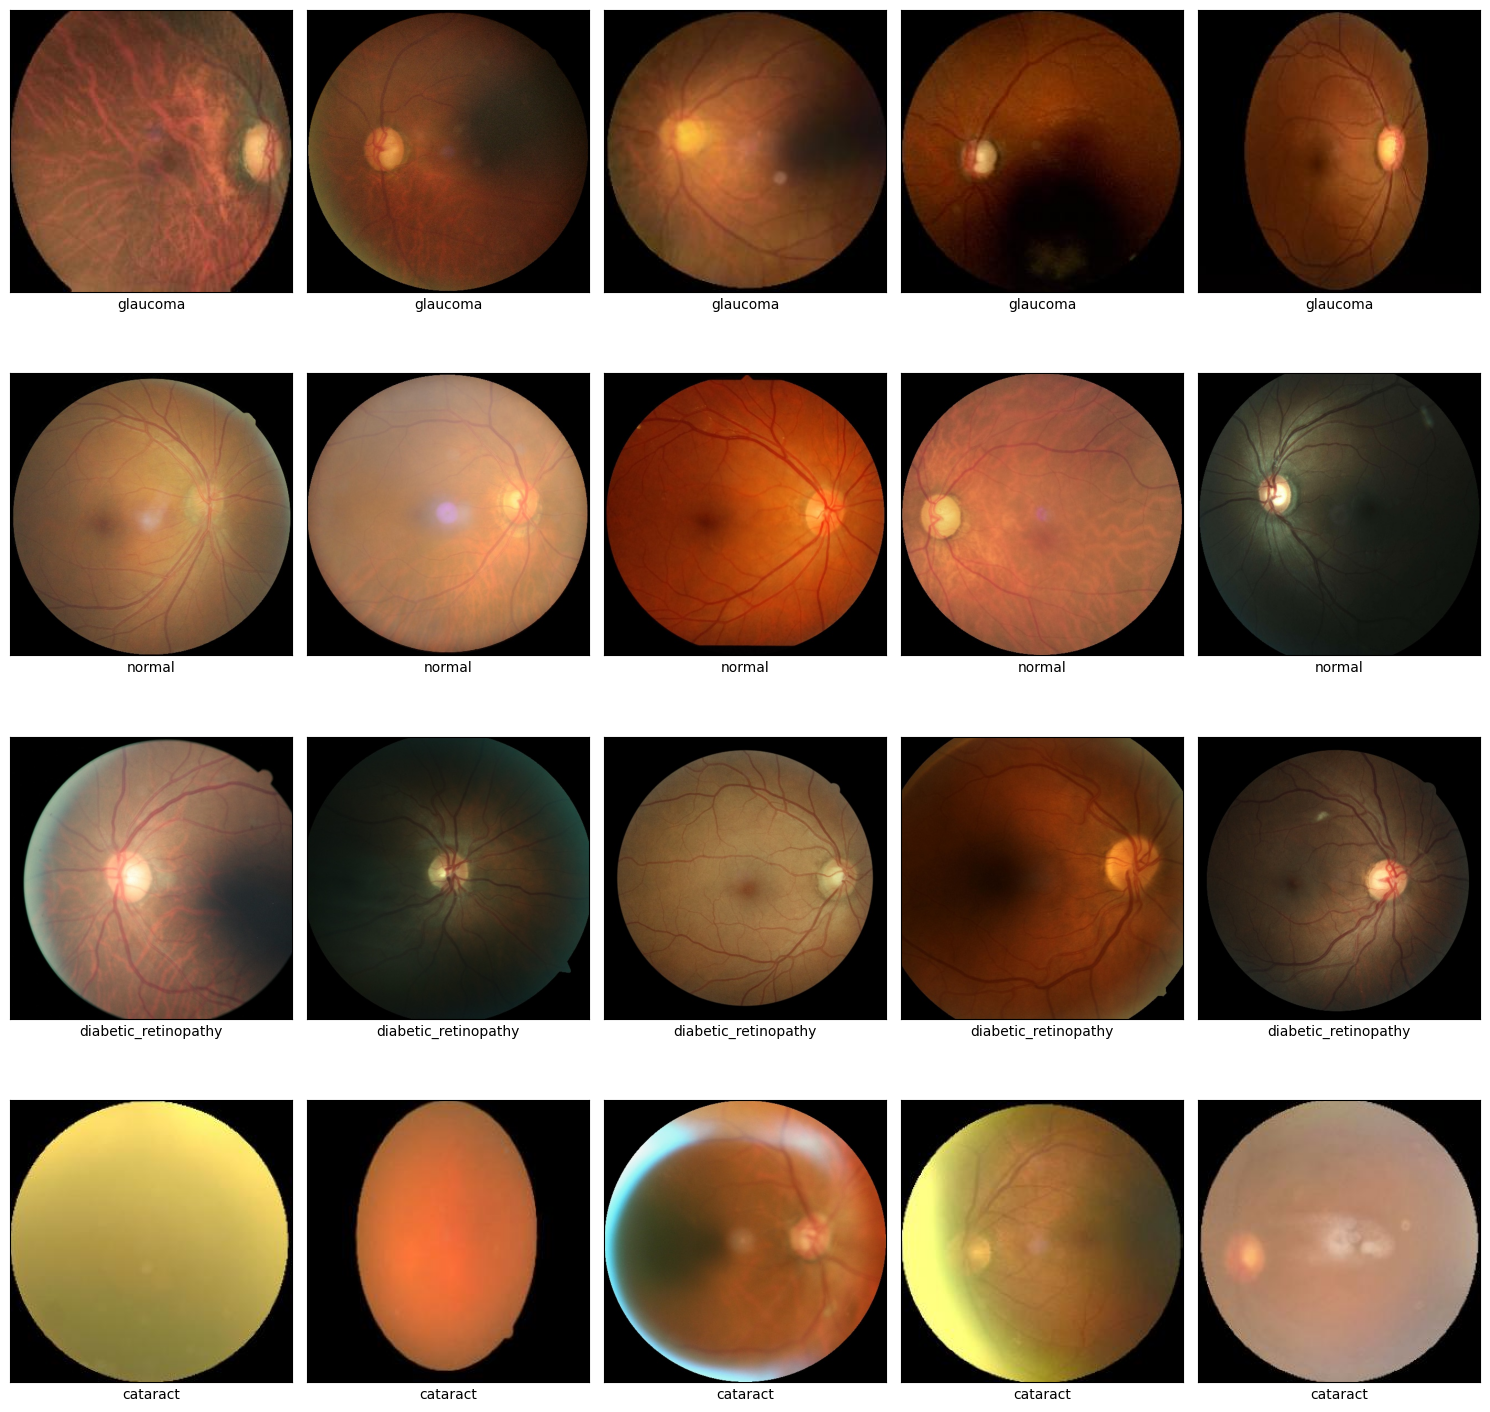

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
eye_image = {}

# Tentukan path sumber train
path = eye_path
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    eye_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(eye_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(eye_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()


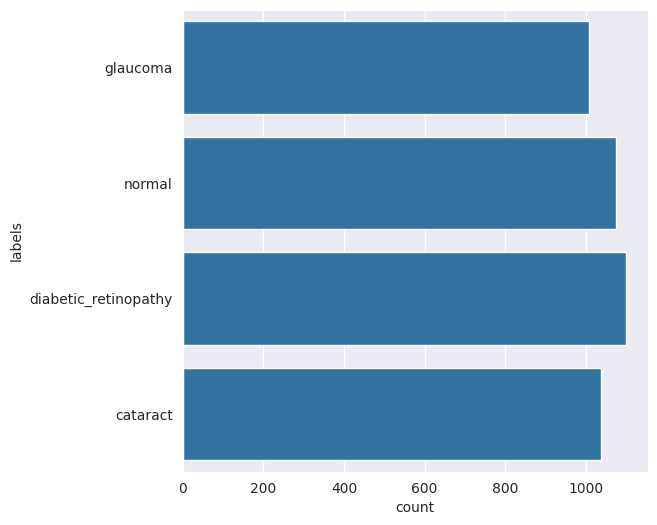

In [11]:
import seaborn as sns
# Definisikan path sumber
eye_path = path

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(eye_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [12]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= eye_path

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
cataract,1038
diabetic_retinopathy,1098
glaucoma,1007
normal,1074


### SPLIT DATASET

In [13]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=300)

In [14]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [15]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/kaggle/input/eye-diseases-classification/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training, validasi dan testing
dataset_path = "Dataset-Final/"


set    labels              
test   cataract                148
       diabetic_retinopathy    160
       glaucoma                164
       normal                  161
train  cataract                890
       diabetic_retinopathy    938
       glaucoma                843
       normal                  913
dtype: int64 


                                                   path    labels    set
2829  /kaggle/input/eye-diseases-classification/data...  cataract  train
2732  /kaggle/input/eye-diseases-classification/data...  cataract  train
3880  /kaggle/input/eye-diseases-classification/data...  glaucoma   test
2583  /kaggle/input/eye-diseases-classification/data...  glaucoma  train
123   /kaggle/input/eye-diseases-classification/data...  cataract  train


In [16]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [17]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"


train_cataract = os.path.join(TRAIN_DIR + '/cataract')
train_diabetic_retinopathy = os.path.join(TRAIN_DIR +'/diabetic_retinopathy')
train_glaucoma = os.path.join(TRAIN_DIR + '/glaucoma')
train_normal = os.path.join(TRAIN_DIR + '/normal')

test_cataract = os.path.join(TEST_DIR + '/cataract')
test_diabetic_retinopathy = os.path.join(TEST_DIR +'/diabetic_retinopathy')
test_glaucoma = os.path.join(TEST_DIR + '/glaucoma')
test_normal = os.path.join(TEST_DIR + '/normal')


print("Total number of cataract images in training set: ",len(os.listdir(train_cataract)))
print("Total number of diabetic retinopathy images in training set: ",len(os.listdir(train_diabetic_retinopathy)))
print("Total number of glaucoma images in training set: ",len(os.listdir(train_glaucoma)))
print("Total number of normal images in training set: ",len(os.listdir(train_normal)))


print("Total number of cataract images in testing set: ",len(os.listdir(test_cataract)))
print("Total number of diabetic retinopathy images in testing set: ",len(os.listdir(test_diabetic_retinopathy)))
print("Total number of glaucoma images in testing set: ",len(os.listdir(test_glaucoma)))
print("Total number of normal images in testing set: ",len(os.listdir(test_normal)))

Total number of cataract images in training set:  890
Total number of diabetic retinopathy images in training set:  938
Total number of glaucoma images in training set:  843
Total number of normal images in training set:  913
Total number of cataract images in testing set:  148
Total number of diabetic retinopathy images in testing set:  160
Total number of glaucoma images in testing set:  164
Total number of normal images in testing set:  161


In [18]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2),
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(299, 299),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
    subset='training'
)


validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(299, 299),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)


test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(299, 299),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)


Found 3049 images belonging to 4 classes.
Found 535 images belonging to 4 classes.
Found 633 images belonging to 4 classes.


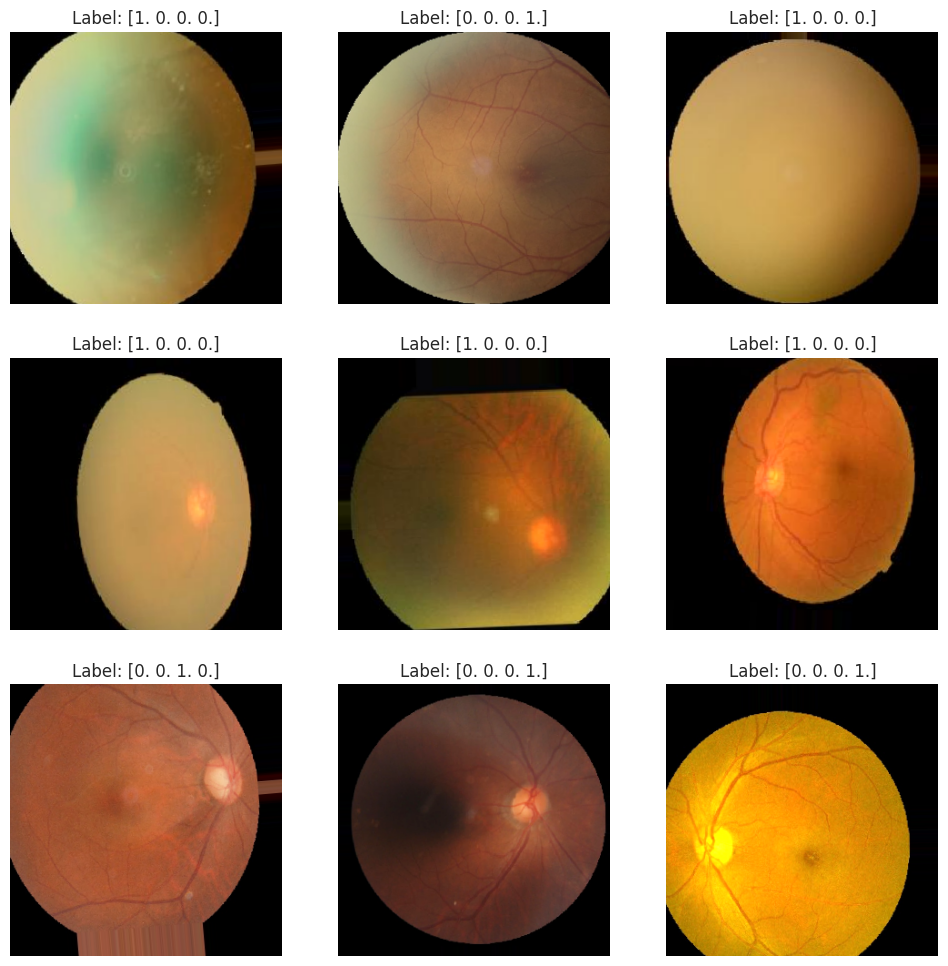

In [22]:
import matplotlib.pyplot as plt

# Mengambil batch gambar dari generator
images, labels = next(train_generator)

# Menampilkan beberapa gambar yang telah di-augmentasi
plt.figure(figsize=(12, 12))
for i in range(9):  # Menampilkan 9 gambar pertama
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')
plt.show()


Data dibagi menjadi tiga bagian, dengan rinciang proporsi masing masing sebagai berikut:

- Training set : 70%
- Validation set: 15%
- Testing set: 15%

##MODELING

In [25]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D

inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
inception_model.trainable = False

model=Sequential()
model.add(inception_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(layers.Dense(256,activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(4,activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,328,356 (85.18 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [26]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4) ,metrics=['accuracy'])

In [27]:
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1)
]


history_1 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=callbacks,
    verbose = 1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4185 - loss: 1.2591
Epoch 1: val_accuracy improved from -inf to 0.65672, saving model to best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1057s 11s/step - accuracy: 0.4196 - loss: 1.2571 - val_accuracy: 0.6567 - val_loss: 0.8247 - learning_rate: 1.0000e-04
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6648 - loss: 0.8154
Epoch 2: val_accuracy improved from 0.65672 to 0.70336, saving model to best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 983s 10s/step - accuracy: 0.6649 - loss: 0.8150 - val_accuracy: 0.7034 - val_loss: 0.7257 - learning_rate: 1.0000e-04
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7169 - loss: 0.6938
Epoch 3: val_accuracy improved from 0.70336 to 0.71269, saving model to best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 978s 10s/step - accuracy: 0.7169 - loss: 0.6938 - val_accuracy: 0.7127 - val_loss: 0.6888 - learning_rate: 1.0000e-04
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - 

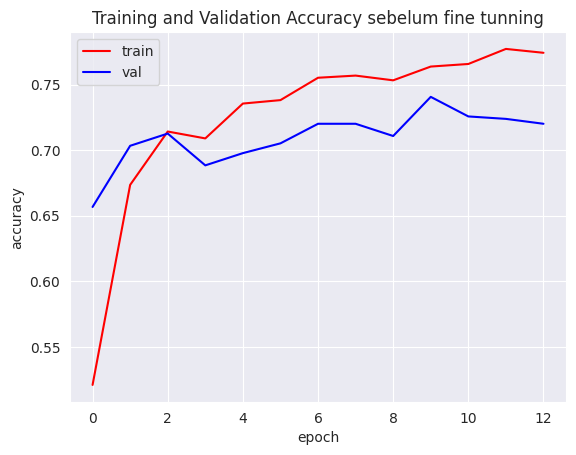

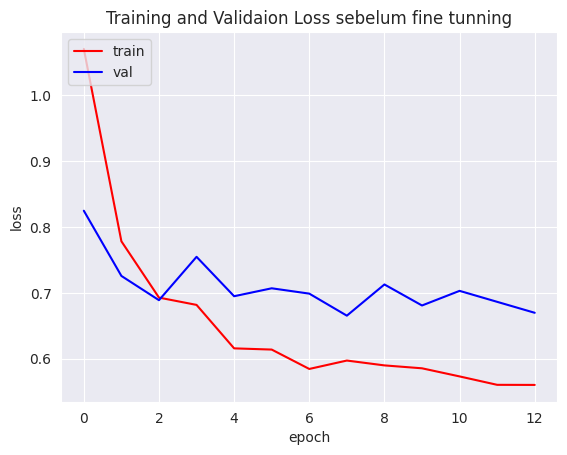

In [55]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy sebelum fine tunning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss sebelum fine tunning')
plt.show()

### MELAKUKAN FINE TUNNING

In [30]:
inception_model.trainable = True


for layer in inception_model.layers[:200]:
    layer.trainable = False


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=23,
    initial_epoch=13,
    callbacks=callbacks
)

Epoch 14/23
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.5501 - loss: 1.1569 
Epoch 14: val_accuracy did not improve from 0.74067
96/96 ━━━━━━━━━━━━━━━━━━━━ 1475s 15s/step - accuracy: 0.5510 - loss: 1.1541 - val_accuracy: 0.6698 - val_loss: 0.7888 - learning_rate: 1.0000e-05
Epoch 15/23
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7959 - loss: 0.5444 
Epoch 15: val_accuracy did not improve from 0.74067
96/96 ━━━━━━━━━━━━━━━━━━━━ 1434s 15s/step - accuracy: 0.7959 - loss: 0.5444 - val_accuracy: 0.7407 - val_loss: 0.6865 - learning_rate: 1.0000e-05
Epoch 16/23
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8124 - loss: 0.4642 
Epoch 16: val_accuracy improved from 0.74067 to 0.75187, saving model to best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1432s 15s/step - accuracy: 0.8125 - loss: 0.4642 - val_accuracy: 0.7519 - val_loss: 0.6635 - learning_rate: 1.0000e-05
Epoch 17/23
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8326 - loss: 0.4225 
Epoch 17: val_accuracy i

KeyboardInterrupt: 

disini entah kenapa proses fine tunning ter interupt, jika mengacu pada errornya dikatakan di interupt oleh keyboard. Jadi saya akan melanjutkan finetunningnya di epoch terakhir sebelum terjadi error

In [31]:
history_3 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=36,
    callbacks=callbacks,
    initial_epoch=19,
    verbose=1
)


Epoch 20/36
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9071 - loss: 0.2512 
Epoch 20: val_accuracy improved from 0.77799 to 0.80597, saving model to best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1419s 15s/step - accuracy: 0.9070 - loss: 0.2514 - val_accuracy: 0.8060 - val_loss: 0.5113 - learning_rate: 1.0000e-05
Epoch 21/36
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9060 - loss: 0.2522 
Epoch 21: val_accuracy did not improve from 0.80597
96/96 ━━━━━━━━━━━━━━━━━━━━ 1386s 14s/step - accuracy: 0.9060 - loss: 0.2523 - val_accuracy: 0.7929 - val_loss: 0.5448 - learning_rate: 1.0000e-05
Epoch 22/36
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9156 - loss: 0.2160 
Epoch 22: val_accuracy did not improve from 0.80597

Epoch 22: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
96/96 ━━━━━━━━━━━━━━━━━━━━ 1399s 15s/step - accuracy: 0.9156 - loss: 0.2161 - val_accuracy: 0.7948 - val_loss: 0.5295 - learning_rate: 1.0000e-05
Epoch 23/36
96/96 ━━━━━━━━━━━━━━

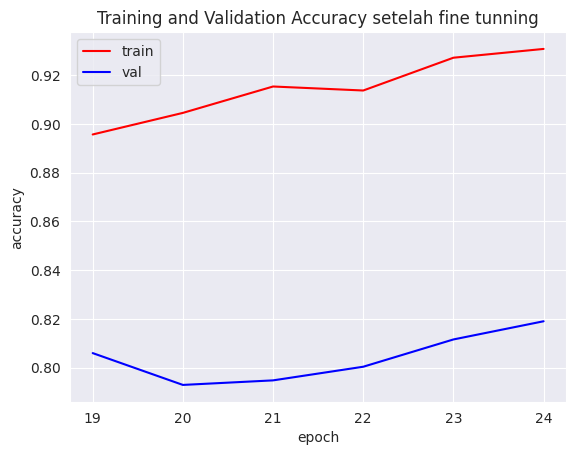

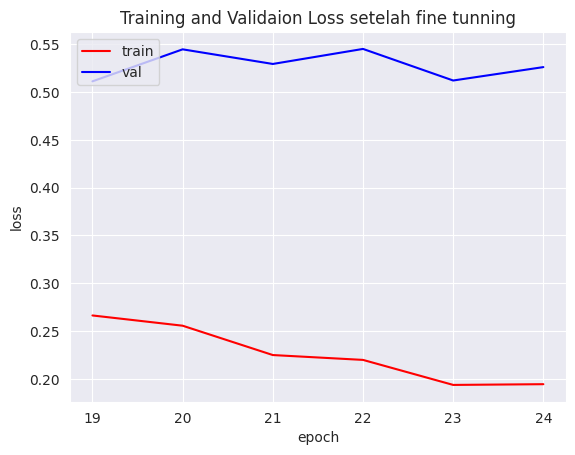

In [58]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(19, 19 + len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy setelah fine tunning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss setelah fine tunning')
plt.show()

INSIGHT:

Akurasi Model pada tahap training setelah fine tunning tampak meyakinkan yakni berhasil menyentuh angka 93%, sehingga saya akan mencoba melakukan testing pada model dengan skor validasi terbaik yang sudah di save melalui model checkpoint.

## EVALUASI DAN VISUALISASI

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()




                      precision    recall  f1-score   support

            cataract     0.9257    0.8726    0.8984       157
diabetic_retinopathy     0.9735    0.9363    0.9545       157
            glaucoma     0.8923    0.7073    0.7891       164
              normal     0.7304    0.9613    0.8301       155

            accuracy                         0.8673       633
           macro avg     0.8805    0.8694    0.8680       633
        weighted avg     0.8811    0.8673    0.8673       633



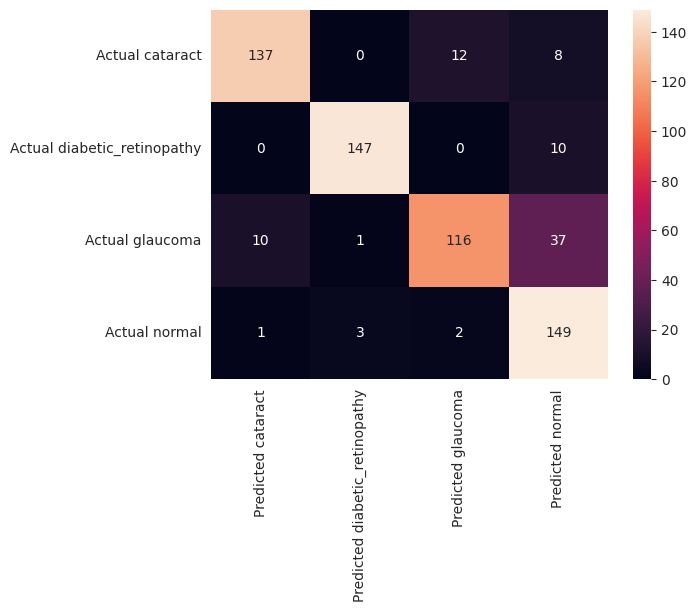

In [35]:
test_generator.reset()


preds_1 = model.predict(test_generator, verbose=0)


preds_1 = np.argmax(preds_1, axis=1)

# Confusion Matrix
labels = list(test_generator.class_indices.keys())
cm = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds_1),
    index=[f"Actual {label}" for label in labels],
    columns=[f"Predicted {label}" for label in labels]
)
sns.heatmap(cm, annot=True, fmt="d")

# Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes, y_pred=preds_1, target_names=labels, digits=4))


INSIGHT:

Model berhasil menyentuh accuracy sebesar 86.73%, selain itu sebaran skor pembanding lainnya pada model juga tampak kuat khususnya pada precision, recall dan f1 score kelas cataract dan diabetic_renopathy. Sedangkan untuk kelas normal dan glaucoma modal cenderung sedikit turun performanya dibandingkan dengan dua kelas lainnya.

## KONVERSI MODEL

In [34]:
model.save("best_model.keras", save_format="tf")

In [36]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open("model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpdtrzmlfl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_933')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138908801423056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801421136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801424592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801425168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801426512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801425360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801426896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801427088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801428048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801422672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389088014

In [37]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [42]:
model.export("saved_model/my_model")

Saved artifact at 'saved_model/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_933')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138908801423056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801421136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801424592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801425168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801426512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801425360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801426896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801427088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801428048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908801422672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138908

In [47]:
!tensorflowjs_converter --input_format=tf_saved_model saved_model/my_model tfjs_model/
!ls tfjs_model/

2025-05-04 01:13:48.952022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746321229.297563  159476 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746321229.396013  159476 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-04 01:14:01.422801: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1746321244.048558  159476 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
import shutil

shutil.make_archive('saved_model', 'zip', 'saved_model')

'/content/saved_model.zip'

In [50]:
!cp saved_model.zip /content/drive/MyDrive/

In [51]:
shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')

'/content/tfjs_model.zip'

In [60]:
!cp tfjs_model.zip /content/drive/MyDrive/

In [54]:
from google.colab import files
files.download('model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>